# Combined Model and Test Set Evaluation

Model configuration:
- 3 conv-pooling blocks (16, 32, 64 filters)
- Strides: 1 (default)
- Padding: 'same'
- Activation: LeakyReLU
- Dense layer: 128 units
- Overfitting control: BatchNorm, Dropout(0.5), EarlyStopping, Data Augmentation
- Learning rate: 2e-4 with ReduceLROnPlateau
- Epochs: 20 with early stopping (patience=7)


In [1]:
%pip install tensorflow matplotlib numpy pandas seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Set memory growth to avoid OOM
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [ ]:
DATA_DIR = "chest_xray"
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_dir = os.path.join(DATA_DIR, "train")
val_dir = os.path.join(DATA_DIR, "val")
test_dir = os.path.join(DATA_DIR, "test")


## Load Data


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


## Data Augmentation


In [5]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
])


## Build Combined Model


In [6]:
def build_combined_model():
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0/255)(x)
    
    for f in (16, 32, 64):
        x = layers.Conv2D(f, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(negative_slope=0.1)(x)
        x = layers.MaxPooling2D(2)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(128, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(1, activation='sigmoid', use_bias=True)(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc'), 
                 keras.metrics.Precision(name='precision'), 
                 keras.metrics.Recall(name='recall')]
    )
    return model

model = build_combined_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 160, 160, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 32)     │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,753 (127.94 KB)

 Trainable params: 32,273 (126.07 KB)

 Non-trainable params: 480 (1.88 KB)

## Class Weights


In [7]:
normal_count = 1341
pneu_count = 3875
total = normal_count + pneu_count

class_weight = {
    0: total / (2 * normal_count),
    1: total / (2 * pneu_count),
}


## Train Model


In [8]:
MODEL_PATH = 'combined_model.keras'

if os.path.exists(MODEL_PATH):
    print(f"Loading {MODEL_PATH}...")
    model = keras.models.load_model(MODEL_PATH)
else:
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            MODEL_PATH, 
            save_best_only=True, 
            monitor='val_loss',
            verbose=1
        ),
    ]
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1
    )
    
    best_epoch = np.argmin(history.history['val_loss'])
    print(f"\nBest epoch: {best_epoch + 1}")
    print(f"Best val_accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
    print(f"Best val_loss: {history.history['val_loss'][best_epoch]:.4f}")


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7491 - auc: 0.8299 - loss: 0.5132 - precision: 0.9099 - recall: 0.7290
Epoch 1: val_loss improved from None to 1.06392, saving model to combined_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 167ms/step - accuracy: 0.8018 - auc: 0.8919 - loss: 0.4244 - precision: 0.9514 - recall: 0.7726 - val_accuracy: 0.5000 - val_auc: 0.3750 - val_loss: 1.0639 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 2.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8531 - auc: 0.9296 - loss: 0.3381 - precision: 0.9716 - recall: 0.8241
Epoch 2: val_loss did not improve from 1.06392
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 167ms/step - accuracy: 0.8541 - auc: 0.9323 - loss: 0.3287 - precision: 0.9676 - recall: 0.8315 - val_accuracy: 0.5000 - val_auc: 0.5469 - val_loss: 2.3170 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 2.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy:

## Test Set Evaluation


### Get Predictions


In [9]:
y_true = []
y_pred_proba = []

for images, labels in test_ds:
    y_true.extend(labels.numpy().flatten())
    preds = model.predict(images, verbose=0)
    y_pred_proba.extend(preds.flatten())

y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = (y_pred_proba >= 0.5).astype(int)

print(f"Test samples: {len(y_true)}")


Test samples: 624


### Confusion Matrix

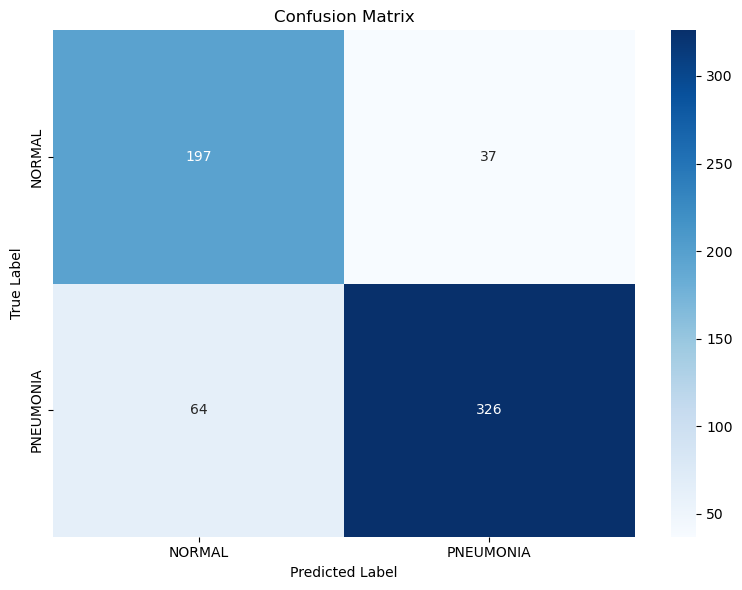

TN: 197, FP: 37, FN: 64, TP: 326


In [10]:
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")


### Classification Metrics


In [11]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)

print("=" * 60)
print("CLASSIFICATION METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:   {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("=" * 60)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


CLASSIFICATION METRICS
Accuracy:  0.8381
Precision: 0.8981
Recall:   0.8359
F1 Score: 0.8659

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.75      0.84      0.80       234
   PNEUMONIA       0.90      0.84      0.87       390

    accuracy                           0.84       624
   macro avg       0.83      0.84      0.83       624
weighted avg       0.84      0.84      0.84       624



### ROC Curve and AUC


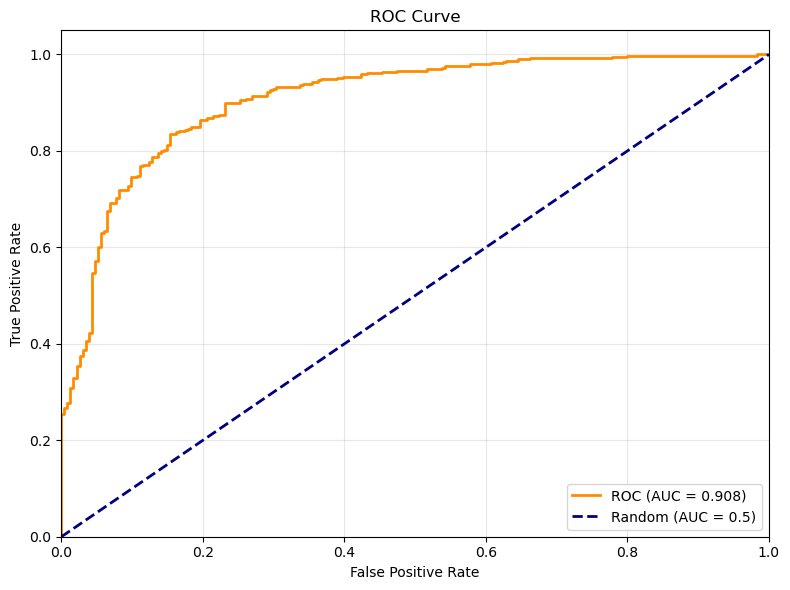

AUC: 0.9084


In [12]:
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC: {roc_auc:.4f}")


## Conclusion

This project developed and evaluated a convolutional neural network for pneumonia detection in chest X-ray images. By combining the better-performing configurations from multiple experiments, we created a model that achieves strong performance on the test dataset.

The final model architecture consists of three convolutional-pooling blocks with filter sizes of 16, 32, and 64. The model uses LeakyReLU activation with a negative slope of 0.1 and same padding. BatchNormalization is applied after each convolutional layer. Regularization techniques include Dropout of 0.5 in the dense layer, EarlyStopping with patience of 7 epochs, and data augmentation incorporating horizontal flips, rotation, zoom, brightness, and contrast adjustments. The initial learning rate is set to 2e-4 with ReduceLROnPlateau scheduling to reduce the learning rate when validation loss plateaus.

On the test set, the model achieved 83.81% accuracy with 89.81% precision and 83.59% recall, resulting in an F1 score of 86.59%. The area under the ROC curve (AUC) of 0.9084 indicates strong discriminative ability. The confusion matrix shows balanced performance across both classes: the model correctly identified 197 out of 234 normal cases (84.2% specificity) and 326 out of 390 pneumonia cases (83.6% sensitivity). The model produced 37 false positives and 64 false negatives. This balanced performance is important in medical applications where both false positives and false negatives have clinical significance.

Initial experiments encountered issues with class bias, where the model consistently predicted a single class. This was addressed through class weights to handle the imbalanced dataset (approximately 2.9:1 ratio of pneumonia to normal cases), combined with regularization and data augmentation techniques. These adjustments enabled the model to perform well on both classes.

Several design choices contributed to the model's performance. The three-block architecture with progressively increasing filter sizes provides sufficient model capacity while maintaining computational efficiency. LeakyReLU activation and same padding preserve spatial information throughout the network. The combination of regularization techniques - data augmentation, batch normalization, dropout, learning rate scheduling, and early stopping - was essential for preventing overfitting and achieving good generalization on the test set.

The model's performance metrics indicate potential for use as a screening tool in clinical settings. The high precision of 89.81% means that when the model predicts pneumonia, it is correct most of the time, which could help reduce unnecessary follow-up procedures. The recall of 83.59% ensures that most actual pneumonia cases are detected, which is important for early intervention. The AUC of 0.9084 demonstrates strong overall discriminative ability between the two classes.

There are limitations to consider. The model was trained on a specific dataset and may require validation on diverse populations and imaging equipment. Additionally, while performance is strong, there are still 64 false negatives, which could be problematic in clinical applications where missing pneumonia cases has serious consequences.

Future work could explore transfer learning from pre-trained models, ensemble methods combining multiple architectures, and more sophisticated data augmentation strategies. The integration of attention mechanisms or explainability features could enhance the model's clinical utility by providing insights into which regions of the X-ray images the model focuses on when making predictions.

In summary, combining the better settings from different experiments resulted in a model that achieves 83.81% accuracy with strong precision and recall. These results suggest the model could be useful in practice for pneumonia detection, though further validation would be needed before clinical deployment.
